In [1]:
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import keras
from keras.models import load_model
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, r2_score
import os

In [111]:
arr = np.load(f'Videos pass obstacle2/{"obstacle_right"}/video{49}.npy')
for frame in arr:
    frame = cv2.resize(frame, (frame.shape[1]*3, frame.shape[0]*3))
    cv2.imshow('1', frame)
    if cv2.waitKey(55) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()

In [ ]:
videos = {'obstacle_right':[], 'obstacle_left':[]}

can = True
for key in videos.keys():
    path = f'Videos pass obstacle/{key}'
    L = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))])
    for i in range(L):
        frames = np.load(f'Videos pass obstacle/{key}/video{i}.npy')
        print(key, i)

In [139]:
videos = {'obstacle_shift_right':[]}

can = True
for key in videos.keys():
    path = f'Videos pass obstacle2/{key}'
    L = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))])
    for i in range(L):
        frames = np.load(f'Videos pass obstacle2/{key}/video{i}.npy')
        print(key, i)
        can = True
        while can:
            for frame in frames:
                frame = cv2.resize(frame, (frame.shape[1]*1, frame.shape[0]*1))
                cv2.imshow('1', frame)
                if cv2.waitKey(55) & 0xFF == ord('q'):
                    can = False
                    break
cv2.destroyAllWindows()

obstacle_shift_right 0


KeyboardInterrupt: 

In [140]:
cv2.destroyAllWindows()

In [146]:
videos = {'go':[], 'obstacle_shift_right':[], 'obstacle_shift_left':[], 'obstacle_right':[], 'obstacle_left':[], 
          'obstacle_stop':[], 'stand_still':[]}
# videos = {'obstacle_right':[], 'obstacle_left':[], 'obstacle_stop':[], 'stand_still':[]}

summ = 0
for key in videos.keys():
    path = f'Videos pass obstacle2/{key}'
    L = len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))])
    for i in range(L):
        video = []
        frames = np.load(f'{path}/video{i}.npy')
        for a in range(len(frames)):
            tmp = cv2.resize(frames[a], (60, 36))
            tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2GRAY)
#             tmp = cv2.adaptiveThreshold(tmp, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 12) 
            video.append(tmp)
        video = np.array(video)
        video = video.reshape((len(video), 36, 60, 1))
        videos[key].append(video)
    summ += len(videos[key])
    print(key, len(videos[key]))
print(summ)

go 47
obstacle_shift_right 182
obstacle_shift_left 187
obstacle_right 19
obstacle_left 28
obstacle_stop 67
stand_still 57
587


In [133]:
for i, name in enumerate([name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]):  # переименование
    print(name, f'{path}video{i}.npy')
    os.rename(f'{path}/{name}', f'{path}/video{i}.npy')

video185.npy Videos pass obstacle2/obstacle_rightvideo0.npy
video186.npy Videos pass obstacle2/obstacle_rightvideo1.npy
video187.npy Videos pass obstacle2/obstacle_rightvideo2.npy
video188.npy Videos pass obstacle2/obstacle_rightvideo3.npy
video189.npy Videos pass obstacle2/obstacle_rightvideo4.npy
video190.npy Videos pass obstacle2/obstacle_rightvideo5.npy
video191.npy Videos pass obstacle2/obstacle_rightvideo6.npy
video192.npy Videos pass obstacle2/obstacle_rightvideo7.npy
video193.npy Videos pass obstacle2/obstacle_rightvideo8.npy
video194.npy Videos pass obstacle2/obstacle_rightvideo9.npy
video195.npy Videos pass obstacle2/obstacle_rightvideo10.npy
video196.npy Videos pass obstacle2/obstacle_rightvideo11.npy
video197.npy Videos pass obstacle2/obstacle_rightvideo12.npy
video198.npy Videos pass obstacle2/obstacle_rightvideo13.npy
video199.npy Videos pass obstacle2/obstacle_rightvideo14.npy
video200.npy Videos pass obstacle2/obstacle_rightvideo15.npy
video23.npy Videos pass obstacle2/

In [135]:
videos['go'][0].shape

(24, 36, 60, 1)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.009, 0.021, 0.046, 0.22, 0.816, 0.999, 1, 1]


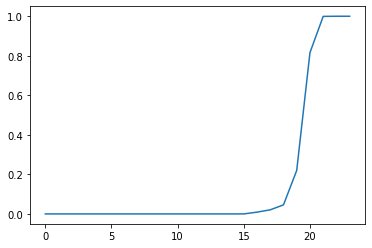

In [148]:
def f_label(index, nof, len_video):
    if index < len_video - nof - 2:
        return 0
    elif index >= len_video - 2:
        return 1
    else:
        x = index + nof - (len_video-2) +2
        label = 0.899*( 1/( 1+np.exp(-3*(x-5.5)) ) + np.power(0.05*x, 2))
        if label > 1:
            label = 1
    return label

len_video = 24
nof = 6
L = list(map(lambda x: f_label(x, nof, len_video), range(len_video)))
print([round(l, 3) for l in L])
plt.plot(list(map(lambda x: f_label(x, nof, len_video), range(len_video))));

In [149]:
nof = 6          #number of frames

X_data, Y_data = [], []
for key in videos.keys():
    for video in videos[key][:-2]:
        len_video = len(video)
        for i in range(len_video-nof*2 + 2):
            inds = list(range(i, i+nof*2-1, 2))
            X_data.append(video[inds])
            if key == 'go' or key == 'stand_still':
                Y_data.append([1, 0, 0, 0, 0, 0])
            if key == 'obstacle_shift_right':
                label = f_label(inds[-1], nof, len_video)
                Y_data.append([1-label, label, 0, 0, 0, 0])
            if key == 'obstacle_shift_left':
                label = f_label(inds[-1], nof, len_video)
                Y_data.append([1-label, 0, label, 0, 0, 0])
            if key == 'obstacle_right':
                label = f_label(inds[-1], nof, len_video)
                Y_data.append([1-label, 0, 0, label, 0, 0])
            if key == 'obstacle_left':
                label = f_label(inds[-1], nof, len_video)
                Y_data.append([1-label, 0, 0, 0, label, 0])
            if key == 'obstacle_stop':
                label = f_label(inds[-1], nof, len_video)
                Y_data.append([1-label, 0, 0, 0, 0, label])
            
X_data = np.array(X_data)
X_data = X_data/255
Y_data = np.array(Y_data)

print(X_data.shape)
print(Y_data.mean(axis=0))

(8444, 6, 36, 60, 1)
[0.76972203 0.08763221 0.09006644 0.00827638 0.01265799 0.03164496]


In [145]:
videos

{'obstacle_shift_right': []}

In [150]:
l = len(X_data)
idx = np.random.permutation(range(len(Y_data)))
X_data, Y_data = X_data[idx,:,:,:,:], Y_data[idx]

n = 0.75
x_train = np.array(X_data[0 : int(n*l)])
y_train = np.array(Y_data[0 : int(n*l)])
x_val = np.array(X_data[int(n*l) : int(1*l)])
y_val = np.array(Y_data[int(n*l) : int(1*l)])
# x_test = np.array(X_data[int(0.9*l) : ])
# y_test = np.array(Y_data[int(0.9*l) : ])

temp_x = []
temp_y = []
for i in range(len(x_train)):
    I = 1
    if y_train[i][0] < 0.1:
        I = 4
    elif y_train[i][0] < 0.2:
        I = 4
    elif y_train[i][0] < 0.8:
        I = 2
    for _ in range(I):
        temp_x.append(x_train[i])
        temp_y.append(y_train[i])
x_train = np.array(temp_x)
y_train = np.array(temp_y)

idx = np.random.permutation(range(len(x_train)))
x_train, y_train = x_train[idx], y_train[idx]
print('train ', x_train.shape, y_train.mean(axis=0))

temp_x = []
temp_y = []
for i in range(len(x_val)):
    I = 1
    if y_val[i][0] < 0.1:
        I = 4
    elif y_val[i][0] < 0.2:
        I = 4
    elif y_val[i][0] < 0.8:
        I = 2
    for _ in range(I):
        temp_x.append(x_val[i])
        temp_y.append(y_val[i])
x_val = np.array(temp_x)
y_val = np.array(temp_y)

idx = np.random.permutation(range(len(x_val)))
x_val, y_val = x_val[idx], y_val[idx]
print('val ', x_val.shape, y_val.mean(axis=0))

# temp_x = []
# temp_y = []
# for i in range(len(x_test)):
#     I = 1
#     if y_test[i][0] < 0.1:
#         I = 8
#     elif y_test[i][0] < 0.2:
#         I = 5
#     elif y_test[i][0] < 0.8:
#         I = 2
#     for _ in range(I):
#         temp_x.append(x_test[i])
#         temp_y.append(y_test[i])
# x_test = np.array(temp_x)
# y_test = np.array(temp_y)

# idx = np.random.permutation(range(len(x_test)))
# x_test, y_test = x_test[idx], y_test[idx]
# print('test ', x_test.shape, y_test.mean(axis=0))


train  (11033, 6, 36, 60, 1) [0.48204676 0.19931234 0.20260074 0.01842987 0.02922252 0.06838777]
val  (3560, 6, 36, 60, 1) [0.50905909 0.17999253 0.19195939 0.01822059 0.0246571  0.0761113 ]


In [14]:
play = True
for video in X_data:
    if play == False:
        break
    for frame in video:
        frame = cv2.resize(frame, (frame.shape[1]*4, frame.shape[0]*4))
        cv2.imshow('1', frame)
        if cv2.waitKey(120) & 0xFF == ord('q'):
            play = False
            break
        
cv2.destroyAllWindows()

In [151]:
videos['obstacle_right'][0][0:6].shape

(6, 36, 60, 1)

In [81]:
model.predict(np.array([videos['obstacle_right'][0][0:6]])/255)

array([[9.9983299e-01, 2.6063202e-05, 1.3699214e-04, 3.8371509e-06]],
      dtype=float32)

In [152]:
from keras.layers import TimeDistributed, Conv2D, Dense, MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from keras import models
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
model = models.Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(1,1),activation='relu'),input_shape=(6, 36, 60, 1)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(Conv2D(16, (3, 3), strides=(1,1),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(TimeDistributed(BatchNormalization()))


model.add(TimeDistributed(Flatten()))
model.add(Dropout(0.4))

model.add(LSTM(64,return_sequences=False,dropout=0.2)) # used 32 units

model.add(Dense(100,activation='relu'))
model.add(Dense(50,activation='sigmoid'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))
model.summary()

# optimizer_new=tf.keras.optimizers.Adam(learning_rate=0.0005)

# model.compile(optimizer=optimizer_new, loss=tf.keras.losses.CategoricalCrossentropy(), 
#                                         metrics=[tf.keras.metrics.CategoricalAccuracy()])

# model.compile(optimizer=optimizer_new, loss=tf.keras.losses.BinaryCrossentropy(), 
#                                         metrics=[tf.keras.metrics.BinaryAccuracy()])
# model.compile(optimizer=optimizer_new, loss='mean_squared_error',metrics=['acc'])

model.compile(loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'],
              optimizer=Lookahead(AdamW(learning_rate=1e-3, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

early = EarlyStopping(monitor="val_loss", mode="min", patience=15, 
                      restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=6, 
                              verbose=1, mode='min', )


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 6, 34, 58, 32)    320       
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 6, 34, 58, 32)    128       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 6, 17, 29, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 6, 15, 27, 16)    4624      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 6, 13, 25, 16)   

In [153]:
# callback=keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True) 
history_new_cnlst = model.fit(x_train, y_train, epochs=1000, batch_size=40, validation_data=(x_val, y_val), 
                              workers=5, callbacks=[reduce_lr, early], )


Epoch 1/1000
276/276 [==============================] - 15s 38ms/step - loss: 0.8896 - categorical_accuracy: 0.6500 - val_loss: 1.2546 - val_categorical_accuracy: 0.4017 - lr: 0.0010
Epoch 2/1000
276/276 [==============================] - 10s 34ms/step - loss: 0.4078 - categorical_accuracy: 0.8653 - val_loss: 0.4550 - val_categorical_accuracy: 0.8115 - lr: 0.0010
Epoch 3/1000
276/276 [==============================] - 10s 34ms/step - loss: 0.3058 - categorical_accuracy: 0.9065 - val_loss: 0.2604 - val_categorical_accuracy: 0.9115 - lr: 0.0010
Epoch 4/1000
276/276 [==============================] - 9s 34ms/step - loss: 0.2584 - categorical_accuracy: 0.9254 - val_loss: 0.2084 - val_categorical_accuracy: 0.9331 - lr: 0.0010
Epoch 5/1000
276/276 [==============================] - 10s 35ms/step - loss: 0.2345 - categorical_accuracy: 0.9351 - val_loss: 0.2051 - val_categorical_accuracy: 0.9306 - lr: 0.0010
Epoch 6/1000
276/276 [==============================] - 10s 34ms/step - loss: 0.2070 -

276/276 [==============================] - 10s 37ms/step - loss: 0.1245 - categorical_accuracy: 0.9905 - val_loss: 0.1443 - val_categorical_accuracy: 0.9730 - lr: 1.0000e-04
Epoch 45/1000
276/276 [==============================] - 10s 36ms/step - loss: 0.1250 - categorical_accuracy: 0.9907 - val_loss: 0.1442 - val_categorical_accuracy: 0.9708 - lr: 1.0000e-04
Epoch 46/1000
276/276 [==============================] - 10s 36ms/step - loss: 0.1253 - categorical_accuracy: 0.9908 - val_loss: 0.1439 - val_categorical_accuracy: 0.9697 - lr: 1.0000e-04
Epoch 47/1000
275/276 [============================>.] - ETA: 0s - loss: 0.1237 - categorical_accuracy: 0.9928
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
276/276 [==============================] - 10s 36ms/step - loss: 0.1237 - categorical_accuracy: 0.9928 - val_loss: 0.1433 - val_categorical_accuracy: 0.9702 - lr: 1.0000e-04
Epoch 48/1000
276/276 [==============================] - 10s 36ms/step - loss: 0.1252 -

276/276 [==============================] - 10s 37ms/step - loss: 0.1235 - categorical_accuracy: 0.9925 - val_loss: 0.1413 - val_categorical_accuracy: 0.9742 - lr: 1.0000e-06
Epoch 86/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1241 - categorical_accuracy: 0.9924 - val_loss: 0.1412 - val_categorical_accuracy: 0.9742 - lr: 1.0000e-06
Epoch 87/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1244 - categorical_accuracy: 0.9924 - val_loss: 0.1412 - val_categorical_accuracy: 0.9742 - lr: 1.0000e-06
Epoch 88/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1234 - categorical_accuracy: 0.9933 - val_loss: 0.1412 - val_categorical_accuracy: 0.9742 - lr: 1.0000e-06
Epoch 89/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1247 - categorical_accuracy: 0.9911 - val_loss: 0.1412 - val_categorical_accuracy: 0.9742 - lr: 1.0000e-06
Epoch 90/1000
276/276 [==============================] - 10s 36ms/step - l

276/276 [==============================] - 10s 37ms/step - loss: 0.1250 - categorical_accuracy: 0.9920 - val_loss: 0.1404 - val_categorical_accuracy: 0.9758 - lr: 1.0000e-06
Epoch 129/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1251 - categorical_accuracy: 0.9932 - val_loss: 0.1403 - val_categorical_accuracy: 0.9758 - lr: 1.0000e-06
Epoch 130/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1257 - categorical_accuracy: 0.9925 - val_loss: 0.1403 - val_categorical_accuracy: 0.9764 - lr: 1.0000e-06
Epoch 131/1000
276/276 [==============================] - 10s 38ms/step - loss: 0.1249 - categorical_accuracy: 0.9924 - val_loss: 0.1403 - val_categorical_accuracy: 0.9764 - lr: 1.0000e-06
Epoch 132/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1252 - categorical_accuracy: 0.9929 - val_loss: 0.1402 - val_categorical_accuracy: 0.9764 - lr: 1.0000e-06
Epoch 133/1000
276/276 [==============================] - 10s 38ms/ste

276/276 [==============================] - 10s 38ms/step - loss: 0.1270 - categorical_accuracy: 0.9935 - val_loss: 0.1399 - val_categorical_accuracy: 0.9770 - lr: 1.0000e-06
Epoch 172/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1278 - categorical_accuracy: 0.9930 - val_loss: 0.1398 - val_categorical_accuracy: 0.9775 - lr: 1.0000e-06
Epoch 173/1000
276/276 [==============================] - 11s 38ms/step - loss: 0.1281 - categorical_accuracy: 0.9914 - val_loss: 0.1398 - val_categorical_accuracy: 0.9775 - lr: 1.0000e-06
Epoch 174/1000
276/276 [==============================] - 10s 38ms/step - loss: 0.1271 - categorical_accuracy: 0.9924 - val_loss: 0.1398 - val_categorical_accuracy: 0.9770 - lr: 1.0000e-06
Epoch 175/1000
276/276 [==============================] - 10s 37ms/step - loss: 0.1274 - categorical_accuracy: 0.9927 - val_loss: 0.1398 - val_categorical_accuracy: 0.9770 - lr: 1.0000e-06
Epoch 176/1000
276/276 [==============================] - 10s 37ms/ste

112/112 [==============================] - 1s 8ms/step - loss: 0.1398 - categorical_accuracy: 0.9770
[0.139797180891037, 0.9769663214683533]


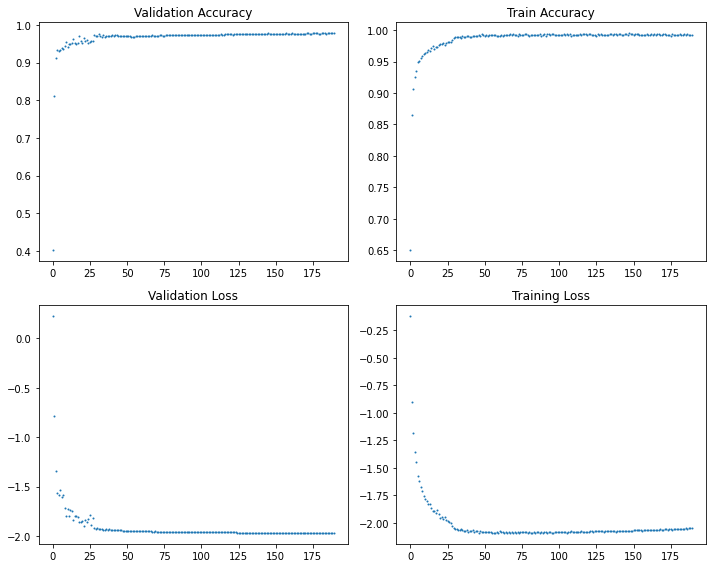

In [154]:
history_k = [i for i in history_new_cnlst.history.keys()]
x = len(history_new_cnlst.history[history_k[0]])
x0 = 0
acc=history_new_cnlst.history[history_k[1]][x0:]
val_acc=history_new_cnlst.history[history_k[3]][x0:]
loss=list(map(math.log , history_new_cnlst.history[history_k[0]][x0:]))
val_loss=list(map(math.log , history_new_cnlst.history[history_k[2]][x0:]))
# loss=history_new_cnlst.history[history_k[0]][x0:]
# val_loss=history_new_cnlst.history[history_k[2]][x0:]
epochs=np.arange(x0,x)

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.scatter(epochs,val_acc, s = 1)
plt.title('Validation Accuracy')

plt.subplot(2,2,2)
plt.scatter(epochs,acc, s = 1)
plt.title('Train Accuracy')

plt.subplot(2,2,3)
plt.scatter(epochs,val_loss, s = 1)
plt.title('Validation Loss')

plt.subplot(2,2,4)
plt.scatter(epochs,loss, s = 1)
plt.title('Training Loss')


plt.tight_layout()

print(model.evaluate(x_val, y_val))


In [ ]:
loss: 0.2172 - categorical_accuracy: 0.9409

In [90]:
print([1-i for i in [0, 0.021, 0.046, 0.22, 0.816, 1,]])

[1, 0.979, 0.954, 0.78, 0.18400000000000005, 0]


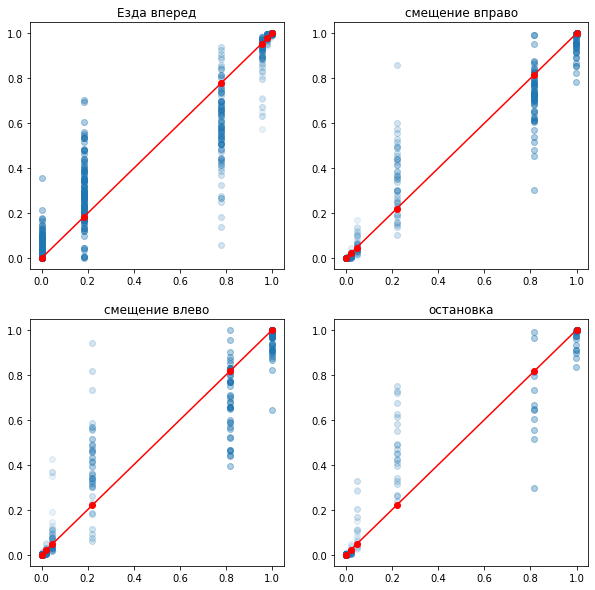

In [91]:
# yp = model.predict(x_val)

xy_best = [0, 0.021, 0.046, 0.22, 0.816, 1,]
xy_best_go = [1, 0.979, 0.954, 0.78, 0.184, 0]

names = ['Езда вперед', 'смещение вправо', 'смещение влево', 'остановка']
fig, ax = plt.subplots(2, 2,  figsize=(10,10))
for a in range(len(yp[0])):
    x = [y[a] for y in y_val]
    y = [y[a] for y in yp]
    ax[int(a/2), a%2].scatter(x, y, alpha = 0.1)
    if a == 0:
        ax[int(a/2), a%2].plot(xy_best_go, xy_best_go, linestyle='-', marker='o', color='red')
    else:
        ax[int(a/2), a%2].plot(xy_best, xy_best, linestyle='-', marker='o', color='red')
    ax[int(a/2), a%2].set_title(names[a])


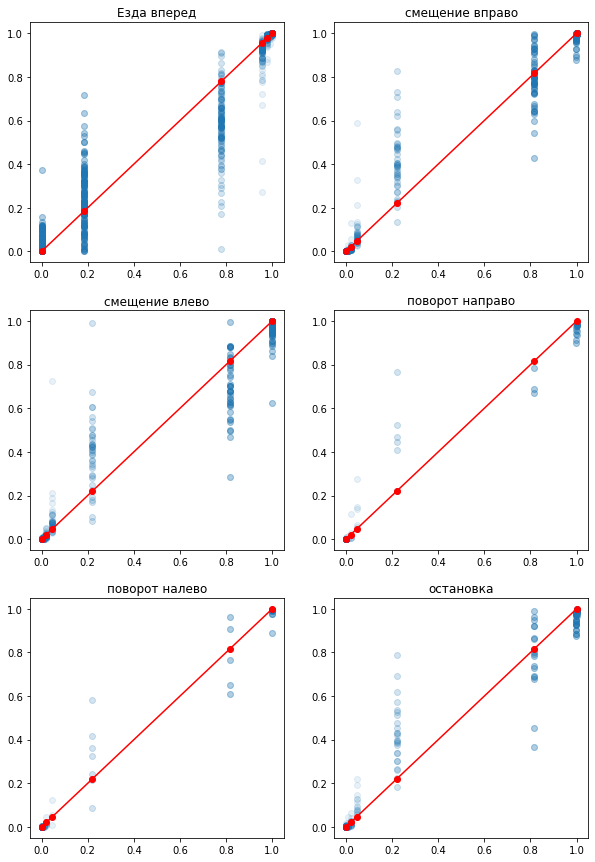

In [161]:
yp = model.predict(x_val)

xy_best = [0, 0.021, 0.046, 0.22, 0.816, 1,]
xy_best_go = [1, 0.979, 0.954, 0.78, 0.184, 0]

names = ['Езда вперед', 'смещение вправо', 'смещение влево', 'поворот направо', 'поворот налево', 'остановка']
fig, ax = plt.subplots(3, 2,  figsize=(10,15))
for a in range(len(yp[0])):
    x = [y[a] for y in y_val]
    y = [y[a] for y in yp]
    ax[int(a/2), a%2].scatter(x, y, alpha = 0.1)
    if a == 0:
        ax[int(a/2), a%2].plot(xy_best_go, xy_best_go, linestyle='-', marker='o', color='red')
    else:
        ax[int(a/2), a%2].plot(xy_best, xy_best, linestyle='-', marker='o', color='red')
    ax[int(a/2), a%2].set_title(names[a])

In [ ]:
roc auc вместос этого

[18:19] Андрей Владимирович Зубюк
    ROC-кривая
​[18:19] Андрей Владимирович Зубюк
    Кривая ошибок
​[18:19] Андрей Владимирович Зубюк
    t - порог
​[18:19] Андрей Владимирович Зубюк
    FP(t), FN(t)
​[18:19] Андрей Владимирович Зубюк
    Precision(t), Recall(t)


In [77]:
y_val[(y_val[:, 1] > 0.3) & (y_val[:, 1] < 0.4)][:50]

array([], shape=(0, 4), dtype=float64)

In [70]:
y_val.shape

(3393, 4)

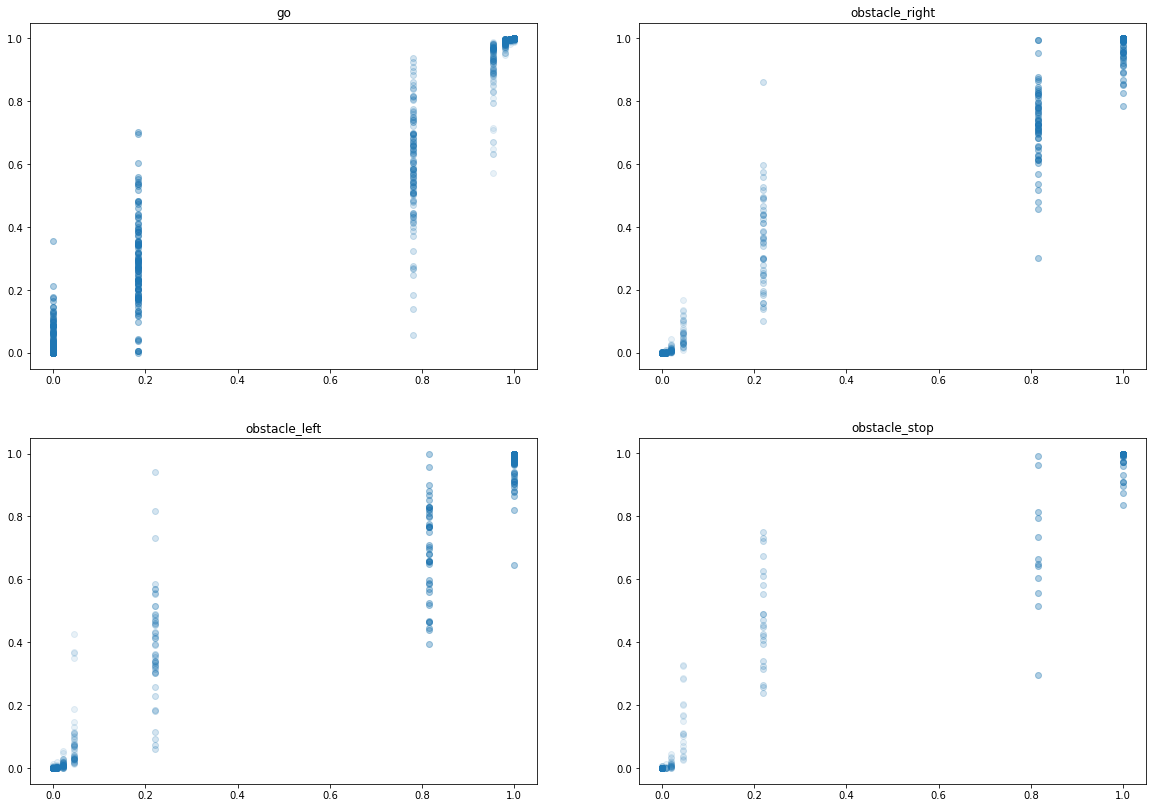

In [24]:
yp = model.predict(x_val)

names = ['go', 'obstacle_right', 'obstacle_left', 'obstacle_stop']
fig, ax = plt.subplots(2, 2,  figsize=(20,14))
for a in range(len(yp[0])):
    x = [y[a] for y in y_val]
    y = [y[a] for y in yp]
    ax[int(a/2), a%2].scatter(x, y, alpha = 0.1)
    ax[int(a/2), a%2].set_title(names[a])


In [162]:
name = 'nn11'

model.save(f'Pass Obstacle Networks/{name}.h5')
run_model = tf.function(lambda x: model(x))

concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([1, 6, 36, 60, 1], model.inputs[0].dtype))

MODEL_DIR = 'Pass Obstacle Networks/TFlite/temp'
model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
tflite_model = converter.convert()

open(f"Pass Obstacle Networks/TFlite/{name}.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: Pass Obstacle Networks/TFlite/temp\assets


INFO:tensorflow:Assets written to: Pass Obstacle Networks/TFlite/temp\assets


1331284

In [49]:
maxx = max(yp[0])
np.where(yp[0] == maxx)[0][0]
yp.max()

0.9999913